In [37]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 26 10:04:06 2017

@author: CarlosABG
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import wb

path = "https://github.com/omercadopopular/cgoes/blob/master/tutorial/python/statatopython/PPI_DB_082316.dta?raw=true"
cpisauce = "https://github.com/omercadopopular/cgoes/blob/master/tutorial/python/statatopython/CPIAUCSL.xls?raw=true"
gdpsauce = "https://github.com/omercadopopular/cgoes/blob/master/tutorial/python/statatopython/gdp.xlsx?raw=true"

In [38]:
#####################################
# 1. Retrieve Databases #############
#####################################

## 1.1 Import GDP data from the World Bank

wbdata = (wb.download(indicator='NY.GDP.MKTP.CD', country='all', start=1994, end=2015)
            .dropna()
            .rename(columns={'NY.GDP.MKTP.CD': 'gdp'})
            )

wbdata.head()

gdp
country    year              
Arab World 2015  2.563721e+12
           2014  2.890239e+12
           2013  2.830840e+12
           2012  2.733908e+12
           2011  2.497297e+12

In [39]:
## 1.2 Read file from STATA dta

ppidf = pd.read_stata(path)

ppidf.head()

,ID,name,IY,country,region,income,IDA,FCY,FCM,type,...,DSU,capacity,pcapacity,technol,bid_crit,CAM,SOS,PRS,MLS,PPP
0,3210,Blue Sky Communications,1999,American Samoa,EAP,UMIC,Non-IDA,1999,July,Greenfield project,...,,Not Available/Other,-8888.0,NA,Not Applicable,N/A,100.0,User fees,Without MLS,Other PPI
1,3210,Blue Sky Communications,2003,American Samoa,EAP,UMIC,Non-IDA,1999,July,Greenfield project,...,,Number of connections (thousands),11.0,NA,Not Applicable,N/A,100.0,User fees,Without MLS,Other PPI
2,3210,Blue Sky Communications,2004,American Samoa,EAP,UMIC,Non-IDA,1999,July,Greenfield project,...,,Number of connections (thousands),13.0,NA,Not Applicable,N/A,100.0,User fees,Without MLS,Other PPI
3,3210,Blue Sky Communications,2005,American Samoa,EAP,UMIC,Non-IDA,1999,July,Greenfield project,...,,Number of connections (thousands),15.0,NA,Not Applicable,N/A,100.0,User fees,Without MLS,Other PPI
4,3210,Blue Sky Communications,2006,American Samoa,EAP,UMIC,Non-IDA,1999,July,Greenfield project,...,,Number of connections (thousands),17.0,NA,Not Applicable,N/A,100.0,User fees,Without MLS,Other PPI


In [40]:
## 1.3 Import CPI data from excel file
    ## Note you have to skip 9 rows

cpi = pd.read_excel(cpisauce, skiprows=9, header=1)

cpi.head()

,observation_date,CPIAUCSL
0,1947-01-01,22.332
1,1948-01-01,24.045
2,1949-01-01,23.809
3,1950-01-01,24.063
4,1951-01-01,25.973


In [41]:
#####################################
# 2. Adjust Databases ###############
#####################################

## 2.1 Adjust WB data

# Reset index

wbdata = wbdata.reset_index()

# Set GDP data to billions

wbdata['gdp'] = wbdata['gdp'] / 10**9

# Iterate through years to convert strings into integers

wbdata['year'] = [int(row) for row in wbdata['year']]

# Set Index

wbdata = wbdata.set_index(['country', 'year'])

wbdata

gdp
country                year             
Arab World             2015  2563.720501
                       2014  2890.239067
                       2013  2830.839875
                       2012  2733.908028
                       2011  2497.297324
                       2010  2103.838827
                       2009  1795.461859
                       2008  2077.760563
                       2007  1637.573471
                       2006  1404.102886
                       2005  1184.661555
                       2004   963.858507
                       2003   821.819709
                       2002   727.949172
                       2001   722.106258
                       2000   733.902979
                       1999   643.095192
                       1998   590.477657
                       1997   612.265868
                       1996   577.272186
                       1995   522.836166
                       1994   486.642376
Caribbean small states 2015    66.935278
                       2014    68.671707
                       2013    68.731748
                       2012    67.849501
                       2011    65.729447
                       2010    60.761150
                       2009    55.921150
                       2008    66.468809
...                                  ...
Zambia                 2001     4.094481
                       2000     3.600683
                       1999     3.404312
                       1998     3.537683
                       1997     4.303282
                       1996     3.597221
                       1995     3.807067
                       1994     3.656648
Zimbabwe               2015    14.419186
                       2014    14.196912
                       2013    13.490227
                       2012    12.392715
                       2011    10.956227
                       2010     9.422161
                       2009     8.157077
                       2008     4.415703
                       2007     5.291950
                       2006     5.443897
                       2005     5.755215
                       2004     5.805598
                       2003     5.727592
                       2002     6.342116
                       2001     6.777385
                       2000     6.689958
                       1999     6.858013
                       1998     6.401968
                       1997     8.529572
                       1996     8.553147
                       1995     7.111271
                       1994     6.890675

[5372 rows x 1 columns]

In [42]:
## 2.2 Adjust PPI database

# Reduce dimensionality to exclude data with negative values and data prior to 1994

ppidf = (ppidf
         [ppidf['investment'] > 0]
         [ppidf['IY'] >= 1994]
         [ppidf['type'] == 'Greenfield project']
         )

# Organize sectors and years

countrieslist = ppidf['country'].unique().sort_values()
sectorslist = ppidf['sector'].unique().sort_values()
years = np.sort(ppidf['IY'].unique())

# Consolidate duplicates
    # We are doing this through loops because the dataset is large
    # and applying a groupby to the whole dataset will demand a lot
    # of RAM

for country in countrieslist:
    grouped = ppidf[ ppidf['country'] == country ]
    sectors = grouped['sector'].unique().sort_values()
    
    for sector in sectors:
        if ( (country == countrieslist[0]) and (sector == sectors[0]) ):
            sectored = grouped[ grouped['sector'] == sector ]
            sectored = sectored.groupby(['country','sector','ID','IY']).mean().dropna()['investment']
            consolidated = sectored
            
        else:
            sectored = grouped[ grouped['sector'] == sector ]
            sectored = sectored.groupby(['country','sector','ID','IY']).mean().dropna()['investment']
            consolidated = consolidated.append(sectored)

consolidated = consolidated.reset_index(drop=False)

# Adjust investments to billion USD

consolidated['investment'] = consolidated['investment'] / 1000

consolidated

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,country,sector,ID,IY,investment
0,Afghanistan,ICT,3064,2003,0.070770
1,Afghanistan,ICT,3064,2004,0.081513
2,Afghanistan,ICT,3064,2005,0.048482
3,Afghanistan,ICT,3064,2006,0.082273
4,Afghanistan,ICT,3064,2007,0.123331
5,Afghanistan,ICT,3064,2008,0.057216
6,Afghanistan,ICT,3064,2009,0.066220
7,Afghanistan,ICT,3832,2005,0.048603
8,Afghanistan,ICT,3832,2006,0.052890
9,Afghanistan,ICT,3832,2007,0.045678


In [43]:
## 2.3 Adjust CPI data

# Extract years and set index

cpi['year'] = [row.year for row in cpi['observation_date']]
cpi = cpi.set_index('year')

cpi

,observation_date,CPIAUCSL
year,,
1947,1947-01-01,22.332
1948,1948-01-01,24.045
1949,1949-01-01,23.809
1950,1950-01-01,24.063
1951,1951-01-01,25.973
1952,1952-01-01,26.567
1953,1953-01-01,26.768
1954,1954-01-01,26.865
1955,1955-01-01,26.796


In [44]:
#####################################
# 3. Brazil Time Series, constant USD
#####################################

## 3.1 Create a new dataset

brazildf = consolidated[ consolidated['country'] == 'Brazil' ]

brazildf

,country,sector,ID,IY,investment
462,Brazil,ICT,969,1997,3.529057
463,Brazil,ICT,969,1998,0.772105
464,Brazil,ICT,969,1999,0.114712
465,Brazil,ICT,969,2000,0.181458
466,Brazil,ICT,969,2001,0.059516
467,Brazil,ICT,969,2002,0.026064
468,Brazil,ICT,969,2003,0.243321
469,Brazil,ICT,969,2004,0.558801
470,Brazil,ICT,969,2005,0.830378
471,Brazil,ICT,969,2006,0.838006


In [45]:
# Collapse data by sector and fill na

brazilinvestment = (brazildf
                    .groupby(['sector','IY']).sum()
                    .fillna(0)
                    ['investment']
                    )

brazilinvestment

sector              IY  
ICT                 1994    0.000000
                    1995    0.000000
                    1996    0.000000
                    1997    3.529057
                    1998    2.335771
                    1999    0.997585
                    2000    2.212553
                    2001    4.542476
                    2002    1.862655
                    2003    0.986021
                    2004    1.489174
                    2005    1.632515
                    2006    1.125373
                    2007    1.048087
                    2008    2.659655
                    2009    1.227820
                    2010    2.006439
                    2011    4.393144
                    2012    4.463429
                    2013    2.910846
                    2014    6.711700
                    2015    0.000000
Energy              1994    0.003194
                    1995    0.003573
                    1996    0.003172
                    1997    1.238719
             

In [46]:
## 3.2 Adjust for Inflation

# Join CPI data

rbrazilinvestment = (
        cpi       
        .join(brazilinvestment.reset_index().set_index('IY'),
              how='inner')
        )
        
# Set Indices and Organize

rbrazilinvestment = (
        rbrazilinvestment
        .reset_index(drop=False)
        .set_index(['sector','index'])
        .sort_index()
        )

rbrazilinvestment

observation_date  CPIAUCSL  investment
sector             index                                       
Energy             1994        1994-01-01   148.225    0.003194
                   1995        1995-01-01   152.383    0.003573
                   1996        1996-01-01   156.858    0.003172
                   1997        1997-01-01   160.525    1.238719
                   1998        1998-01-01   163.008    0.766153
                   1999        1999-01-01   166.583    2.667381
                   2000        2000-01-01   172.192    2.848069
                   2001        2001-01-01   177.042    3.498204
                   2002        2002-01-01   179.867    3.374498
                   2003        2003-01-01   184.000    3.203816
                   2004        2004-01-01   188.908    1.019335
                   2005        2005-01-01   195.267    2.655137
                   2006        2006-01-01   201.558    3.290321
                   2007        2007-01-01   207.344    5.622762
                   2008        2008-01-01   215.254    5.882005
                   2009        2009-01-01   214.565   22.500077
                   2010        2010-01-01   218.076    6.732983
                   2011        2011-01-01   224.923   12.948761
                   2012        2012-01-01   229.586   25.857938
                   2013        2013-01-01   232.949    5.884229
                   2014        2014-01-01   236.704    7.060100
                   2015        2015-01-01   236.987    2.071280
ICT                1994        1994-01-01   148.225    0.000000
                   1995        1995-01-01   152.383    0.000000
                   1996        1996-01-01   156.858    0.000000
                   1997        1997-01-01   160.525    3.529057
                   1998        1998-01-01   163.008    2.335771
                   1999        1999-01-01   166.583    0.997585
                   2000        2000-01-01   172.192    2.212553
                   2001        2001-01-01   177.042    4.542476
...                                   ...       ...         ...
Transport          2008        2008-01-01   215.254    0.566657
                   2009        2009-01-01   214.565    1.214024
                   2010        2010-01-01   218.076    0.803640
                   2011        2011-01-01   224.923    1.731076
                   2012        2012-01-01   229.586    1.052172
                   2013        2013-01-01   232.949    5.418408
                   2014        2014-01-01   236.704    3.849800
                   2015        2015-01-01   236.987    0.040100
Water and sewerage 1994        1994-01-01   148.225    0.000000
                   1995        1995-01-01   152.383    0.078925
                   1996        1996-01-01   156.858    0.068574
                   1997        1997-01-01   160.525    0.000000
                   1998        1998-01-01   163.008    0.013648
                   1999        1999-01-01   166.583    0.000000
                   2000        2000-01-01   172.192    0.000000
                   2001        2001-01-01   177.042    0.015247
                   2002        2002-01-01   179.867    0.000000
                   2003        2003-01-01   184.000    0.001287
                   2004        2004-01-01   188.908    0.005016
                   2005        2005-01-01   195.267    0.000000
                   2006        2006-01-01   201.558    0.000000
                   2007        2007-01-01   207.344    0.000000
                   2008        2008-01-01   215.254    0.315457
                   2009        2009-01-01   214.565    0.000000
                   2010        2010-01-01   218.076    0.000000
                   2011        2011-01-01   224.923    0.000000
                   2012        2012-01-01   229.586    0.000000
                   2013        2013-01-01   232.949    0.000000
                   2014        2014-01-01   236.704    1.112000
                   2015        2015-01-01   236.987    0.

In [47]:
## Update CPI frame with necessary data

cpi = (rbrazilinvestment
        .reset_index(drop=False)
        .groupby('index').mean()
        .drop(['investment'], axis=1)
        ['CPIAUCSL']
        )
   
# Adjust for Inflation

rbrazilinvestment['rinvestment'] = rbrazilinvestment['investment'] / rbrazilinvestment['CPIAUCSL']  * cpi[2014]

# Only keep real investment data

rbrazilinvestment = rbrazilinvestment['rinvestment']

rbrazilinvestment

sector              index
Energy              1994      0.005101
                    1995      0.005551
                    1996      0.004787
                    1997      1.826567
                    1998      1.112531
                    1999      3.790181
                    2000      3.915103
                    2001      4.677076
                    2002      4.440821
                    2003      4.121500
                    2004      1.277239
                    2005      3.218575
                    2006      3.864060
                    2007      6.418948
                    2008      6.468145
                    2009     24.821654
                    2010      7.308113
                    2011     13.626990
                    2012     26.659628
                    2013      5.979079
                    2014      7.060100
                    2015      2.068807
ICT                 1994      0.000000
                    1995      0.000000
                    1996      0.000000

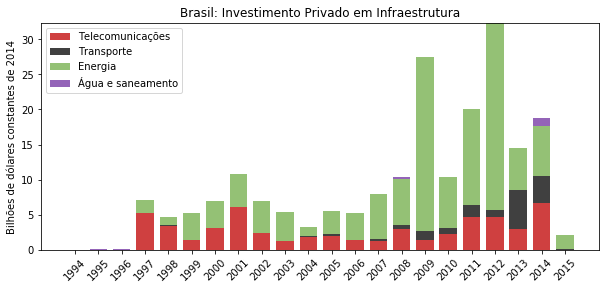

In [48]:
## 3.2 Plot chart

f, ax = plt.subplots(1, figsize=(10,5))
barw = 0.75
barl = [i+1 for i in range(len(years))]

ax.bar(barl, rbrazilinvestment['ICT'], barw, color='#c00000',
       alpha=0.75,
       label="Telecomunicações")

ax.bar(barl, rbrazilinvestment['Transport'], barw, color='#000000',
       bottom=rbrazilinvestment['ICT'],
       alpha=0.75,
       label="Transporte")

ax.bar(barl, rbrazilinvestment['Energy'], barw, color='#70ac47',
       bottom=[i+j for i,j in zip(rbrazilinvestment['ICT'],
                                  rbrazilinvestment['Transport']
                                  )],
       alpha=0.75,
       label="Energia")

ax.bar(barl, rbrazilinvestment['Water and sewerage'], barw, color='#7030a0',
       bottom=[i+j+k for i,j,k in zip(rbrazilinvestment['ICT'],
                                      rbrazilinvestment['Transport'],
                                      rbrazilinvestment['Energy']
                                      )],
       alpha=0.75,
       label="Água e saneamento")

ax.set_ylabel("Bilhões de dólares constantes de 2014")
plt.legend(loc='upper left')

plt.title('Brasil: Investimento Privado em Infraestrutura')

plt.subplots_adjust(bottom=0.25)

plt.xticks(barl, years, rotation=45)

plt.show()

In [49]:
#####################################
# 4. Brazil Time Series, share of GDP
#####################################

## 4.1 Import GDP data from World Bank Dataset

# Create new series with Brazil GDP data

brazilgdp = wbdata.loc['Brazil'].reset_index()

brazilgdp

,year,gdp
0,2015,1803.652650
1,2014,2455.993200
2,2013,2472.806920
3,2012,2465.188674
4,2011,2616.201578
5,2010,2208.871646
6,2009,1667.019606
7,2008,1695.824517
8,2007,1397.084382
9,2006,1107.640325


In [50]:
# Join both dataframes

brazilinvestment = (brazilgdp.set_index('year')
                    .join(brazilinvestment
                          .reset_index()
                          .set_index('IY'),
                                    how='right')
                    )
                    
brazilinvestment

,gdp,sector,investment
1994,558.111997,ICT,0.000000
1994,558.111997,Energy,0.003194
1994,558.111997,Transport,0.000000
1994,558.111997,Water and sewerage,0.000000
1995,785.643456,ICT,0.000000
1995,785.643456,Energy,0.003573
1995,785.643456,Transport,0.000000
1995,785.643456,Water and sewerage,0.078925
1996,850.425828,ICT,0.000000
1996,850.425828,Energy,0.003172


In [51]:
# Set new indices

brazilinvestment = brazilinvestment.reset_index(drop=False).set_index(['sector','index'])

brazilinvestment

,,gdp,investment
sector,index,,
ICT,1994,558.111997,0.000000
Energy,1994,558.111997,0.003194
Transport,1994,558.111997,0.000000
Water and sewerage,1994,558.111997,0.000000
ICT,1995,785.643456,0.000000
Energy,1995,785.643456,0.003573
Transport,1995,785.643456,0.000000
Water and sewerage,1995,785.643456,0.078925
ICT,1996,850.425828,0.000000


In [53]:
## 4.2 Calculate GDP shares
                    
brazilinvestment['investmentgdp'] = ( brazilinvestment['investment'] / ( brazilinvestment['gdp']  ) ) * 100

brazilinvestment

,,gdp,investment,investmentgdp
sector,index,,,
ICT,1994,558.111997,0.000000,0.000000
Energy,1994,558.111997,0.003194,0.000572
Transport,1994,558.111997,0.000000,0.000000
Water and sewerage,1994,558.111997,0.000000,0.000000
ICT,1995,785.643456,0.000000,0.000000
Energy,1995,785.643456,0.003573,0.000455
Transport,1995,785.643456,0.000000,0.000000
Water and sewerage,1995,785.643456,0.078925,0.010046
ICT,1996,850.425828,0.000000,0.000000


In [55]:
# Only keep investment to GDP Data

brazilinvestmentgdp = brazilinvestment['investmentgdp']

brazilinvestmentgdp

sector              index
ICT                 1994     0.000000
Energy              1994     0.000572
Transport           1994     0.000000
Water and sewerage  1994     0.000000
ICT                 1995     0.000000
Energy              1995     0.000455
Transport           1995     0.000000
Water and sewerage  1995     0.010046
ICT                 1996     0.000000
Energy              1996     0.000373
Transport           1996     0.000000
Water and sewerage  1996     0.008063
ICT                 1997     0.399576
Energy              1997     0.140254
Transport           1997     0.000000
Water and sewerage  1997     0.000000
ICT                 1998     0.270430
Energy              1998     0.088703
Transport           1998     0.013952
Water and sewerage  1998     0.001580
ICT                 1999     0.166434
Energy              1999     0.445017
Transport           1999     0.000000
Water and sewerage  1999     0.000000
ICT                 2000     0.337577
Energy              2000

In [56]:
# Export to CSV

brazilinvestment.unstack().to_csv("K://Notas Técnicas//Produtividade//Databases//PPI World Bank//brazilinvestment.csv",
                        sep=";",
                        decimal=",")

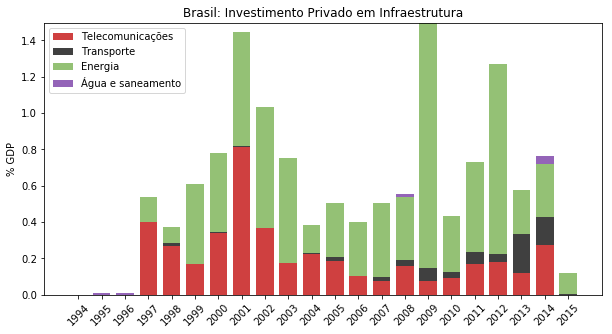

In [57]:
## 4.3 Plot chart

f, ax = plt.subplots(1, figsize=(10,5))
barw = 0.75
barl = [i+1 for i in range(len(years))]

ax.bar(barl, brazilinvestmentgdp['ICT'], barw, color='#c00000',
       alpha=0.75,
       label="Telecomunicações")

ax.bar(barl, brazilinvestmentgdp['Transport'], barw, color='#000000',
       bottom=brazilinvestmentgdp['ICT'],
       alpha=0.75,
       label="Transporte")

ax.bar(barl, brazilinvestmentgdp['Energy'], barw, color='#70ac47',
       bottom=[i+j for i,j in zip(brazilinvestmentgdp['ICT'],
                                  brazilinvestmentgdp['Transport']
                                  )],
       alpha=0.75,
       label="Energia")

ax.bar(barl, brazilinvestmentgdp['Water and sewerage'], barw, color='#7030a0',
       bottom=[i+j+k for i,j,k in zip(brazilinvestmentgdp['ICT'],
                                      brazilinvestmentgdp['Transport'],
                                      brazilinvestmentgdp['Energy']
                                      )],
       alpha=0.75,
       label="Água e saneamento")

ax.set_ylabel("% GDP")
plt.legend(loc='upper left')

plt.title('Brasil: Investimento Privado em Infraestrutura')

plt.xticks(barl, years, rotation=45)

plt.show()

In [59]:
#####################################
# 5. Cross Section, 2010-2014 avg ###
#####################################


## 5.1 Consolidate 2010-2014 investment average

average = consolidated[ (consolidated['IY'] > 2009) & (consolidated['IY'] < 2015) ].copy()

# Sum across investment types

average = average.groupby(['country','IY']).sum()['investment']

# Take period average

average = average.reset_index(drop=False).groupby('country').mean().drop(['IY'], axis=1)

average

,investment
country,
Afghanistan,0.061919
Albania,0.520795
Algeria,0.392970
American Samoa,NaN
Angola,0.220664
Antigua and Barbuda,NaN
Argentina,2.216221
Armenia,0.125503
Azerbaijan,0.076202


In [61]:
## 5.2 Consolidate 2010-2014 GDP average

averagegdp = wbdata.reset_index().copy()
averagegdp = averagegdp[ (averagegdp['year'] > 2009) & (averagegdp['year'] < 2015) ]

averagegdp

,country,year,gdp
1,Arab World,2014,2890.239067
2,Arab World,2013,2830.839875
3,Arab World,2012,2733.908028
4,Arab World,2011,2497.297324
5,Arab World,2010,2103.838827
23,Caribbean small states,2014,68.671707
24,Caribbean small states,2013,68.731748
25,Caribbean small states,2012,67.849501
26,Caribbean small states,2011,65.729447
27,Caribbean small states,2010,60.761150


In [62]:
# Take period average

averagegdp = averagegdp.groupby(['country']).mean()

averagegdp

,year,gdp
country,,
Afghanistan,2012.0,18.900021
Albania,2012.0,12.627699
Algeria,2012.0,198.794699
American Samoa,2012.0,0.614200
Andorra,2011.5,3.292154
Angola,2012.0,110.734829
Antigua and Barbuda,2012.0,1.178347
Arab World,2012.0,2611.224624
Argentina,2012.0,515.623579


In [63]:
## 5.3 Join both dataframes

average = average.join(averagegdp, how='inner')

average

,investment,year,gdp
country,,,
Afghanistan,0.061919,2012.0,18.900021
Albania,0.520795,2012.0,12.627699
Algeria,0.392970,2012.0,198.794699
American Samoa,NaN,2012.0,0.614200
Angola,0.220664,2012.0,110.734829
Antigua and Barbuda,NaN,2012.0,1.178347
Argentina,2.216221,2012.0,515.623579
Armenia,0.125503,2012.0,10.550539
Azerbaijan,0.076202,2012.0,67.268746


In [65]:
## 5.4 Calculate shares of GDP

average['investmentgdp'] = average['investment'] / ( average['gdp'] ) * 100

average

,investment,year,gdp,investmentgdp
country,,,,
Afghanistan,0.061919,2012.0,18.900021,0.327616
Albania,0.520795,2012.0,12.627699,4.124229
Algeria,0.392970,2012.0,198.794699,0.197676
American Samoa,NaN,2012.0,0.614200,NaN
Angola,0.220664,2012.0,110.734829,0.199273
Antigua and Barbuda,NaN,2012.0,1.178347,NaN
Argentina,2.216221,2012.0,515.623579,0.429814
Armenia,0.125503,2012.0,10.550539,1.189541
Azerbaijan,0.076202,2012.0,67.268746,0.113280


In [67]:
## 5.5 Calculate percentiles

average['pctile'] = average['investmentgdp'].rank(pct=True) * 100

average

,investment,year,gdp,investmentgdp,pctile
country,,,,,
Afghanistan,0.061919,2012.0,18.900021,0.327616,17.272727
Albania,0.520795,2012.0,12.627699,4.124229,97.272727
Algeria,0.392970,2012.0,198.794699,0.197676,9.090909
American Samoa,NaN,2012.0,0.614200,NaN,NaN
Angola,0.220664,2012.0,110.734829,0.199273,10.000000
Antigua and Barbuda,NaN,2012.0,1.178347,NaN,NaN
Argentina,2.216221,2012.0,515.623579,0.429814,21.818182
Armenia,0.125503,2012.0,10.550539,1.189541,69.090909
Azerbaijan,0.076202,2012.0,67.268746,0.113280,5.454545


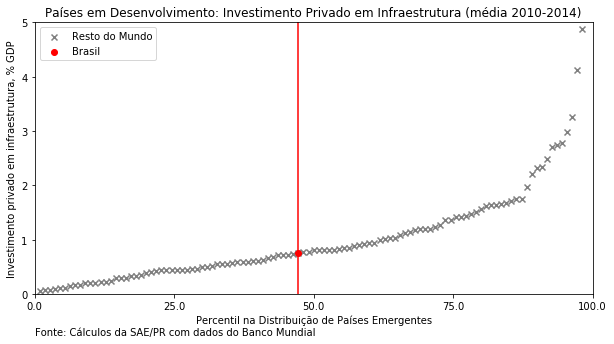

In [68]:
## 5.6 Plot Charts

f, ax = plt.subplots(1, figsize=(10,5))
plt.axis([0,100,0,5])
plt.xticks(np.linspace(0,100,5), np.linspace(0,100,5))

ax.scatter(average['pctile'] , average['investmentgdp'], color='grey', label='Resto do Mundo', marker='x')

ax.scatter(average.loc['Brazil']['pctile'], average.loc['Brazil']['investmentgdp'], color='red', label='Brasil')

plt.axvline(average.loc['Brazil']['pctile'], color='red') 

plt.legend(loc='upper left')

ax.set_xlabel("Percentil na Distribuição de Países Emergentes")
ax.set_ylabel("Investimento privado em infraestrutura, % GDP")


plt.title('Países em Desenvolvimento: Investimento Privado em Infraestrutura (média 2010-2014)')

plt.text(0,-0.75,'Fonte: Cálculos da SAE/PR com dados do Banco Mundial')

plt.show()